In [1]:
import os
import bopt
import tqdm
import torch
import numpy as np

from pyDOE2.doe_lhs import lhs
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import median_absolute_deviation, wilcoxon

%load_ext autoreload
%autoreload 2

##### save images and set to use the libertine font (required for ACM)

In [2]:
save_images = False

In [3]:
if save_images:
    # configure matplotlib to use latex so we're able to use the libertine font
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}',
                                           r'\usepackage[libertine]{newtxmath}',
                                           r'\usepackage{sfmath}',
                                           r'\usepackage[T1]{fontenc}'
                                          ]
    
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['backend'] = 'pdf'
    
else:
    plt.rcParams['text.usetex'] = False

In [4]:
start_run = 1
end_run = 51
problems = [('Branin', {}),
            ('Eggholder', {}),
            ('GoldsteinPrice', {}),
            ('SixHumpCamel',{} ),
            ('Shekel', {}),
            ('Ackley', {'d': 5}),
            ('Hartmann6', {}),
            ('Michalewicz', {'d': 10}),
            ('Rosenbrock', {'d': 10}),
            ('StyblinskiTang', {'d': 10}),
            ('push4', {}),
            ('push8', {}),
            ]

mean_names = ['MeanZero',
              'MeanMedian',
              'MeanMin',
              'MeanMax',
              'MeanLinearCV',
              'MeanQuadraticCV',
              'MeanRandomForrest',
              'MeanRBFCV',
              ]

acq_names = ['EI']

# Evaluate the prediction error of the GP + mean function
For each of the synthetic functions + push4 + push8:
- Select $N = 1000$ LHS locations
- for each of the 51 optimisation runs
    - Evaluate the LHS locations on the function $\mathbf{f} = \{ f_1, f_2, \dots, f_N\}$
    - Train a model using the first 100 training points (i.e. those chosen during optimisation)
    - Predict the values $\{ \hat{f}_1, \hat{f}_2, \dots, \hat{f}_N\}$ of the LHS locations
- save the LHS locations and their function values for each problem instance

NRMSE for each problem instance:
\begin{equation}
NRMSE = \frac{\sqrt{ \frac{1}{N} \sum_{i=1}^N ( f_i - \hat{f_i} )^2 }} { f_{max} - f_{min}},
\end{equation}
where $f_{max}$ and $f_{min}$ are the largest and smallest values of the test locations $\mathbf{f}$ respectively.

#### Replace "False" with "True" on the line below to rerun the experiments

In [5]:
if False:
    N_TEST = 1000
    acq_name = 'EI'
    n_train = 100

    transform_function = getattr(bopt.transforms, 'Transform_Standardize')
    ls_bounds = [1e-6, 1e6]
    out_bounds = [1e-6, 1e6]

    total = 51 * len(problems) * len(mean_names)

    with tqdm.notebook.tqdm(total=total) as pbar:

        for problem_name, problem_params in problems:
            # load basic version of the problem to get its dimension and bounds
            f_class = getattr(bopt.test_problems, problem_name)
            f = f_class(**problem_params)
            f = bopt.util.TorchProblem(bopt.util.UniformProblem(f))
            problem_bounds = torch.stack((f.lb, f.ub))

            # result storage
            r = {'Xtest': torch.tensor(lhs(f.dim, N_TEST)),
                 'Ftest': torch.zeros((51, N_TEST)),
                 'preds': {mean_name: torch.zeros((51, N_TEST)) for mean_name in mean_names}
                 }

            for i, run_no in enumerate(range(start_run, end_run + 1)):
                # ---------------- load problem instance data
                data_path = bopt.util.generate_data_filename(problem_name, run_no,
                                                             problem_params, data_dir='data')
                data = torch.load(data_path)
                if 'problem_params' in data:
                    problem_params.update(data['problem_params'])

                # instantiate problem instance and its bounds
                f_class = getattr(bopt.test_problems, problem_name)
                f = f_class(**problem_params)
                f = bopt.util.TorchProblem(bopt.util.UniformProblem(f))
                problem_bounds = torch.stack((f.lb, f.ub))

                # evaluate the LHS test points for this problem instance
                r['Ftest'][i, :] = f(r['Xtest'])

                # ------------ mean function evaluation
                for mean_name in mean_names:
                    # load the training data
                    fn = bopt.util.generate_save_filename(problem_name, mean_name, 
                                                          acq_name, run_no, 
                                                          problem_params=problem_params)
                    data = torch.load(fn)
                    Ytr = data['Ytr'][n_train:, ]
                    Xtr = data['Xtr'][n_train:, ]

                    T_out = transform_function(Ytr)
                    train_y = T_out.scale_mean(Ytr)
                    train_x = Xtr

                    # instantiate the mean function and train the model
                    mean_func = getattr(bopt.mean_functions, mean_name)
                    mf = mean_func(train_x, train_y)

                    model, likelihood = bopt.gp.create_and_fit_GP(train_x, train_y, ls_bounds,
                                                                  out_bounds, mf, n_restarts=2)

                    # predict the test data
                    model.eval()
                    with torch.no_grad():
                        observed_pred = likelihood(
                            model(r['Xtest']),
                            noise=model.likelihood.noise.mean().expand(N_TEST)
                        )

                        mu = observed_pred.mean
                        mu = T_out.unscale_mean(mu)  # unscale mean

                    # store the result
                    r['preds'][mean_name][i, :] = mu

                    print(problem_name, 
                          'instance', run_no,
                          mean_name, 
                          'RMSE:', torch.mean(torch.pow(mu - r['Ftest'][i, :], 2)).item())

                    pbar.update()
                print()

            save_path = f'rmse_results/RMSE_{problem_name}.pt'
            torch.save(obj=r, f=save_path)

# Boxplot results

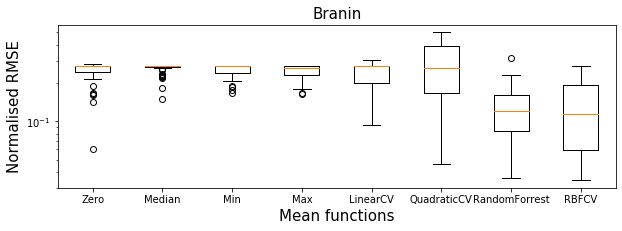

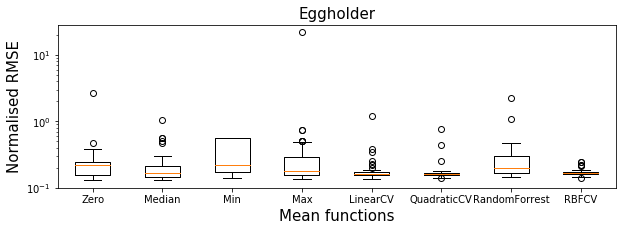

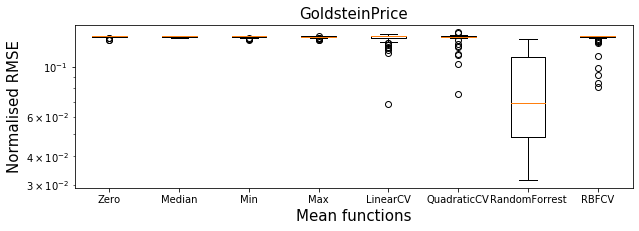

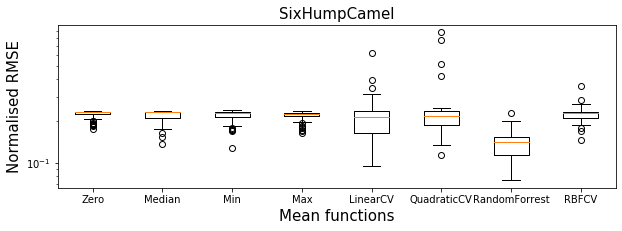

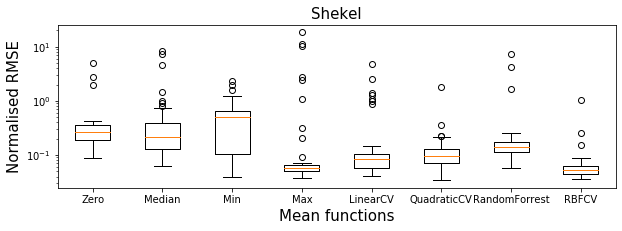

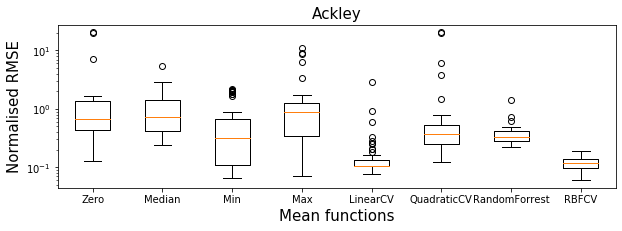

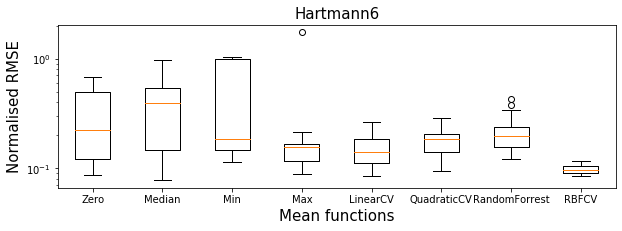

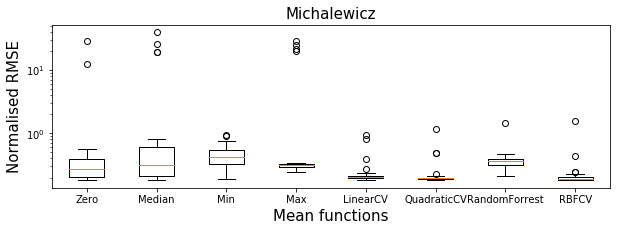

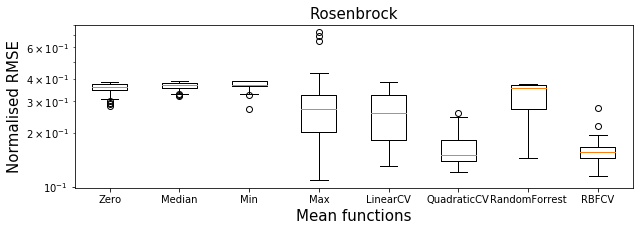

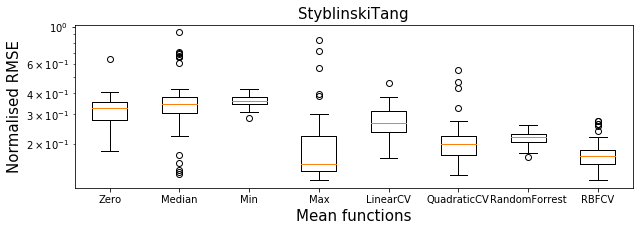

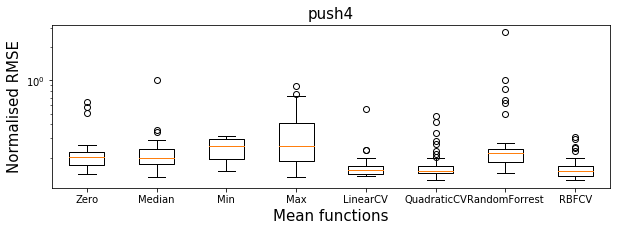

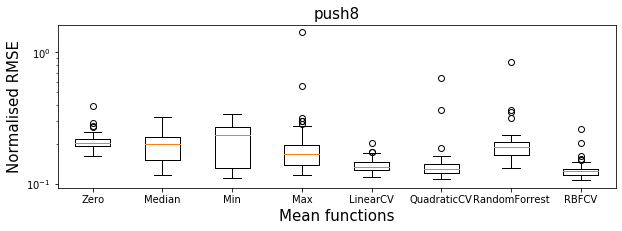

In [6]:
for i, (problem_name, problem_params) in enumerate(problems):
    fn = f'rmse_results/RMSE_{problem_name}.pt'
    
    if not os.path.exists(fn):
        continue

    data = torch.load(fn)
    Ftest = data['Ftest'].numpy()
    preds = {key: value.numpy() for key, value in data['preds'].items()}

    boxplot_data = []
    boxplot_labels = []
    for j, mean_function in enumerate(preds):
        MSE = np.mean(np.square(Ftest - preds[mean_function]), axis=1)
        RMSE = np.sqrt(MSE)

        NRMSE = RMSE / (np.max(Ftest, axis=1) - np.min(Ftest, axis=1))

        boxplot_data.append(NRMSE)
        boxplot_labels.append(mean_function[4:])

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.boxplot(boxplot_data, labels=boxplot_labels)
    ax.set_title(problem_name, fontsize=15)
    ax.set_xlabel('Mean functions', fontsize=15)
    ax.set_ylabel('Normalised RMSE', fontsize=15)
    ax.semilogy()
    plt.show()

# create table data (with stats tests)

In [7]:
td = {}

for problem_name, problem_params in problems:
    
    # ---------- load
    fn = f'rmse_results/RMSE_{problem_name}.pt'
    
    if not os.path.exists(fn):
        continue

    data = torch.load(fn)
    Ftest = data['Ftest'].numpy()
    preds = {key: value.numpy() for key, value in data['preds'].items()}
    
    sigmaF = np.std(Ftest, axis=1)
    maxF = np.max(Ftest, axis=1)
    minF = np.min(Ftest, axis=1)
    
    # ---------- process
    err = np.zeros((len(mean_names), 51))
    for i, mean_name in enumerate(mean_names):
        MSE = np.mean(np.square(Ftest - preds[mean_name]), axis=1)
        RMSE = np.sqrt(MSE)
        
        NRMSE = RMSE / (maxF - minF)
        
        err[i, :] = NRMSE
        
    median_err = np.median(err, axis=1)
    mad_err = median_absolute_deviation(err, axis=1)
    
    # idx of best mean function
    best_idx = np.argmin(median_err)
    
    # mask of methods equivlent to the best
    stats_equal_to_best_mask = np.zeros(len(mean_names), dtype='bool')
    stats_equal_to_best_mask[best_idx] = True
    
    # perform wilcoxon signed rank test between best and all other methods
    p_values = []
    for i, mean_name in enumerate(mean_names):
        if i == best_idx:
            continue

        # a ValueError will be thrown if the runs are all identical,
        # therefore we can assign a p-value of 0 as they are identical
        try:
            _, p_value = wilcoxon(err[best_idx, :], err[i, :])
            p_values.append(p_value)

        except ValueError:
            p_values.append(0)
            
    # calculate the Holm-Bonferroni correction
    reject_hyp, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05,
                                                      method='holm')

    for reject, mean_name in zip(reject_hyp, [m for m in mean_names
                                   if m != mean_names[best_idx]]):
        # if we can't reject the hypothesis that a technique is
        # statistically equivalent to the best method
        if not reject:
            idx = np.where(np.array(mean_names) == mean_name)[0][0]
            stats_equal_to_best_mask[idx] = True
            
    td[problem_name] = {'medians': median_err,
                        'mads': mad_err,
                        'best_mask': stats_equal_to_best_mask,
                        'best_idx': best_idx,
                        'err': err}

In [8]:
# labels for the table heading
mean_labels = []
for j, mean_name in enumerate(mean_names):
    mean_name = mean_name[4:]
    
    if mean_name == 'LinearCV':
        mean_name = 'Lin'
        
    if mean_name == 'QuadraticCV':
        mean_name = 'Quad'
        
    if mean_name == 'RandomForrest':
        mean_name = 'RF'
        
    if mean_name == 'RBFCV':
        mean_name = 'RBF'
        
    if mean_name == 'Zero':
        mean_name = 'Arith'
        
    if mean_name == 'Median':
        mean_name = 'Med'
        
    mean_labels.append(mean_name)

In [9]:
s = ''
for j, mean_name in enumerate(mean_labels):
    s += f' & {mean_name:s}'
s += ' \\\\\n\\toprule'
print(s)


for problem_name, _ in problems:
    s = f'{problem_name:s} '
    
    for i, mean_name in enumerate(mean_names):
        s += ' & '
        
        # if the best method
        if i == td[problem_name]['best_idx']:
            s += r'\best '
        
        # if stats equiv
        elif td[problem_name]['best_mask'][i]:
            s += r'\statsimilar '
            
        s += f"{td[problem_name]['medians'][i]:0.3f}"
    s += r' \\'
    print(s)

 & Arith & Med & Min & Max & Lin & Quad & RF & RBF \\
\toprule
Branin  & 0.271 & 0.271 & 0.271 & 0.263 & 0.270 & 0.263 & \statsimilar 0.121 & \best 0.114 \\
Eggholder  & 0.217 & \statsimilar 0.165 & 0.216 & 0.177 & \best 0.161 & \statsimilar 0.163 & 0.198 & \statsimilar 0.166 \\
GoldsteinPrice  & 0.136 & 0.136 & 0.136 & 0.136 & 0.136 & 0.136 & \best 0.069 & 0.136 \\
SixHumpCamel  & 0.232 & 0.231 & 0.231 & 0.223 & 0.215 & 0.216 & \best 0.142 & 0.228 \\
Shekel  & 0.265 & 0.215 & 0.494 & \statsimilar 0.058 & 0.083 & 0.094 & 0.142 & \best 0.053 \\
Ackley  & 0.663 & 0.716 & 0.316 & 0.899 & \best 0.107 & 0.378 & 0.334 & \statsimilar 0.117 \\
Hartmann6  & 0.222 & 0.394 & 0.184 & 0.154 & 0.140 & 0.185 & 0.195 & \best 0.097 \\
Michalewicz  & 0.271 & 0.311 & 0.417 & 0.316 & 0.205 & \statsimilar 0.193 & 0.360 & \best 0.190 \\
Rosenbrock  & 0.362 & 0.368 & 0.371 & 0.270 & 0.257 & \best 0.151 & 0.355 & \statsimilar 0.157 \\
StyblinskiTang  & 0.325 & 0.347 & 0.360 & \best 0.151 & 0.267 & \statsimila